In [17]:
import os
import csv
import random
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import BSE

random.seed(42)
np.random.seed(42)

In [18]:
sess_id = "q3_demo_default"

start_time = 0
end_time = 60 * 5

buyers_spec = [
    ('ZIP', 5),
    ('ZIC', 5)
]

sellers_spec = [
    ('ZIP', 5),
    ('SHVR', 5)
]


mrktmakers_spec = [
    ('MMM01', 1, {})
]

traders_spec = {
    'buyers': buyers_spec,
    'sellers': sellers_spec,
    'mrktmakers': mrktmakers_spec
}

sup_range = (100, 200)
dem_range = (100, 200)

supply_schedule = [
    {'from': start_time, 'to': end_time, 'ranges': [sup_range], 'stepmode': 'fixed'}
]
demand_schedule = [
    {'from': start_time, 'to': end_time, 'ranges': [dem_range], 'stepmode': 'fixed'}
]

order_schedule = {
    'sup': supply_schedule,
    'dem': demand_schedule,
    'interval': 30,
    'timemode': 'drip-jitter'
}

dumpfile_flags = {
    'dump_strats': False,
    'dump_lobs': False,
    'dump_tape': False,
    'dump_blotters': False,
    'dump_avgbals': True
}

BSE.market_session(
    sess_id=sess_id,
    starttime=start_time,
    endtime=end_time,
    trader_spec=traders_spec,
    order_schedule=order_schedule,
    dumpfile_flags=dumpfile_flags,
    sess_vrbs=True,
)

print(f"Session {sess_id} finished.")
print(f"Check file: {sess_id}_avg_balance.csv")


import BSE
import sys

def mmm01_getorder_forced_patch(self, time, countdown, lob):
    if len(self.orders) < 1 or time < 60:
        order = None
    else:
        quoteprice = self.orders[0].price
        order = BSE.Order(self.tid,
                      self.orders[0].otype,
                      quoteprice,
                      self.orders[0].qty,
                      time, lob['QID'])
        self.lastquote = order
    return order

BSE.TraderMMM01.getorder = mmm01_getorder_forced_patch
print("Must 60s")



MM01 init: n_past_trades=1, bid_percent=0.50000, ask_delta=25


q3_demo_default;  
trader=S08 order=None
trader=B02 order=None
trader=B02 order=None
trader=S05 order=None
trader=B02 order=None
trader=S07 order=None
trader=B04 order=None
trader=B04 order=None
trader=S05 order=None
trader=S07 order=None
trader=B05 order=None
trader=B08 order=None
trader=S06 order=None
trader=S09 order=None
trader=S03 order=None
trader=B06 order=None
trader=S07 order=None
trader=B06 order=None
trader=B09 order=None
trader=S02 order=None
trader=M00 order=None
trader=S01 order=None
trader=S04 order=None
trader=S06 order=None
trader=S04 order=None
trader=B03 order=[B03 Bid P=096 Q=1 T= 1.19 QID:0]
trader=B07 order=None
trader=B07 order=None
trader=B02 order=None
trader=S00 order=None
trader=B00 order=None
trader=S08 order=None
trader=S07 order=None
trader=B07 order=None
trader=S08 order=None
trader=B07 order=None
trader=B00 order=None
trader=B02 order=None
trader=M00 order=None
trader=B01 order=None
trader=B

In [19]:
def get_mmm01_profit_from_avg_balance(sess_id, initial_balance=500.0):
   
    filename = f"{sess_id}_avg_balance.csv"
    if not os.path.exists(filename):
        raise FileNotFoundError(f"{filename} not found. Did you run the session with dump_avgbals=True?")

    with open(filename, 'r') as f:
        rows = list(csv.reader(f))

    last_row = rows[-1]

    mmm_avg_balance = None

    for i in range(4, len(last_row), 4):
        ttype = last_row[i].strip()
        if ttype == 'MMM01':
            try:
                avg_balance_str = last_row[i + 3]
                mmm_avg_balance = float(avg_balance_str)
            except (IndexError, ValueError):
                continue

    if mmm_avg_balance is None:
        raise ValueError("No MMM01 data found in avg_balance file.")

    profit = mmm_avg_balance - initial_balance
    return profit

demo_profit = get_mmm01_profit_from_avg_balance("q3_demo_default")
print("Demo MMM01 profit (approx):", demo_profit)


Demo MMM01 profit (approx): 0.0


In [20]:
def run_single_mmm01_experiment(sess_prefix, 
                                run_id, 
                                mmm_params, 
                                market_type="synthetic", 
                                end_time=60 * 5, 
                                seed=None):

    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)

    start_time = 0
    sess_id = f"{sess_prefix}_{market_type}_{run_id}"

    if market_type == "synthetic":
    
        sup_range = (100, 200)
        dem_range = (100, 200)

        supply_schedule = [
            {'from': start_time, 'to': end_time, 'ranges': [sup_range], 'stepmode': 'fixed'}
        ]
        demand_schedule = [
            {'from': start_time, 'to': end_time, 'ranges': [dem_range], 'stepmode': 'fixed'}
        ]

    elif market_type == "ibm_offset":
        price_offset_filename = "offset-ibm-1m-170831.csv"
        offsetfn = BSE.offset_from_file(
            price_offset_filename=price_offset_filename,
            time_col=1,
            price_col=5,
            scale_factor=75,
            end_time=end_time
        )

        base_sup = (120, 220)
        base_dem = (80, 180)

        sup_range = (base_sup[0], base_sup[1], offsetfn)
        dem_range = (base_dem[0], base_dem[1], offsetfn)

        supply_schedule = [
            {'from': start_time, 'to': end_time, 'ranges': [sup_range], 'stepmode': 'fixed'}
        ]
        demand_schedule = [
            {'from': start_time, 'to': end_time, 'ranges': [dem_range], 'stepmode': 'fixed'}
        ]

    else:
        raise ValueError(f"Unknown market_type: {market_type}")

    order_schedule = {
        'sup': supply_schedule,
        'dem': demand_schedule,
        'interval': 30,
        'timemode': 'drip-jitter'
    }

    buyers_spec = [
        ('ZIP', 4),
        ('ZIC', 4),
        ('GVWY', 2)
    ]
    
    sellers_spec = [
        ('ZIP', 4),
        ('SHVR', 4),
        ('GVWY', 2)
    ]
    
    mrktmakers_spec = [
        ('MMM01', 1, mmm_params)
    ]

    traders_spec = {
        'buyers': buyers_spec,
        'sellers': sellers_spec,
        'mrktmakers': mrktmakers_spec
    }

    dumpfile_flags = {
        'dump_strats': False,
        'dump_lobs': False,
        'dump_tape': False,
        'dump_blotters': False,
        'dump_avgbals': True
    }

    BSE.market_session(
        sess_id=sess_id,
        starttime=start_time,
        endtime=end_time,
        trader_spec=traders_spec,
        order_schedule=order_schedule,
        dumpfile_flags=dumpfile_flags,
        sess_vrbs=False
    )

    try:
        profit = get_mmm01_profit_from_avg_balance(sess_id)
    except Exception as e:
        print(f"Warning: Could not read profit for {sess_id}. Reason: {e}")
        profit = 0.0

    return profit

In [21]:
default_params = {
    "n_past_trades": 1,
    "bid_percent": 0.5,
    "ask_delta": 25
}

p_syn = run_single_mmm01_experiment(
    sess_prefix="q3_test",
    run_id="syn",
    mmm_params=default_params,
    market_type="synthetic",
    end_time=60 * 5
)

p_ibm = run_single_mmm01_experiment(
    sess_prefix="q3_test",
    run_id="ibm",
    mmm_params=default_params,
    market_type="ibm_offset",
    end_time=60 * 5
)

print("Synthetic market, MMM01 profit:", p_syn)
print("IBM-offset market, MMM01 profit:", p_ibm)


MM01 init: n_past_trades=1, bid_percent=0.50000, ask_delta=25

MM01 init: n_past_trades=1, bid_percent=0.50000, ask_delta=25

Synthetic market, MMM01 profit: 0.0
IBM-offset market, MMM01 profit: 0.0


In [29]:
n_past_trades_list = [1, 5, 10]
bid_percent_list = [0.9, 0.95, 0.98]
ask_delta_list = [5, 10, 25, 50]

param_grid = list(itertools.product(n_past_trades_list,
                                    bid_percent_list,
                                    ask_delta_list))

print("Number of parameter combinations:", len(param_grid))

N_runs = 5

all_results = []

for (n_past, bid_pct, ask_dlt) in param_grid:
    mmm_params = {
        "n_past_trades": n_past,
        "bid_percent": bid_pct,
        "ask_delta": ask_dlt
    }

    for market_type in ["synthetic", "ibm_offset"]:
        for run in range(N_runs):
            seed = 1000 + run
            profit = run_single_mmm01_experiment(
                sess_prefix="q3",
                run_id=f"{market_type}_{n_past}_{bid_pct}_{ask_dlt}_{run}",
                mmm_params=mmm_params,
                market_type=market_type,
                end_time=60 * 5, 
                                  
                seed=seed
            )

            all_results.append({
                "n_past_trades": n_past,
                "bid_percent": bid_pct,
                "ask_delta": ask_dlt,
                "market_type": market_type,
                "run": run,
                "profit": profit
            })

df_results = pd.DataFrame(all_results)
df_results.to_csv("q3_mmm01_param_sweep_results_stage.csv", index=False)

df_results.head()


Number of parameter combinations: 36
MM01 init: n_past_trades=1, bid_percent=0.90000, ask_delta=5

t=176.476190 (0h02m56s) M00 (MMM01) bookkeep: orders=[M00 Bid P=123 Q=1 T=176.43 QID:2019] Balance=378 NetWorth=500
t=180.428571 (0h03m00s) M00 (MMM01) bookkeep: orders=[M00 Ask P=127 Q=1 T=180.38 QID:2061] Balance=509 NetWorth=509
t=193.523810 (0h03m13s) M00 (MMM01) bookkeep: orders=[M00 Bid P=153 Q=1 T=193.43 QID:2170] Balance=357 NetWorth=509
MM01 init: n_past_trades=1, bid_percent=0.90000, ask_delta=5

t=71.761905 (0h01m11s) M00 (MMM01) bookkeep: orders=[M00 Bid P=145 Q=1 T=50.67 QID:403] Balance=355 NetWorth=500
t=80.571429 (0h01m20s) M00 (MMM01) bookkeep: orders=[M00 Ask P=150 Q=1 T=80.52 QID:744] Balance=510 NetWorth=510
t=113.285714 (0h01m53s) M00 (MMM01) bookkeep: orders=[M00 Bid P=158 Q=1 T=113.24 QID:1052] Balance=353 NetWorth=510
t=168.190476 (0h02m48s) M00 (MMM01) bookkeep: orders=[M00 Ask P=162 Q=1 T=168.00 QID:1603] Balance=517 NetWorth=517
t=193.142857 (0h03m13s) M00 (MMM0

,n_past_trades,bid_percent,ask_delta,market_type,run,profit
0,1,0.9,5,synthetic,0,-143.0
1,1,0.9,5,synthetic,1,22.0
2,1,0.9,5,synthetic,2,0.0
3,1,0.9,5,synthetic,3,0.0
4,1,0.9,5,synthetic,4,23.0


In [30]:
summary = (
    df_results
    .groupby(["n_past_trades", "bid_percent", "ask_delta", "market_type"])
    .agg(mean_profit=("profit", "mean"),
         std_profit=("profit", "std"),
         n=("profit", "size"))
    .reset_index()
)

summary.head()


,n_past_trades,bid_percent,ask_delta,market_type,mean_profit,std_profit,n
0,1,0.9,5,ibm_offset,24.6,20.513410,5
1,1,0.9,5,synthetic,-19.6,69.894921,5
2,1,0.9,10,ibm_offset,19.4,11.567195,5
3,1,0.9,10,synthetic,-10.4,55.193297,5
4,1,0.9,25,ibm_offset,-97.4,103.628181,5


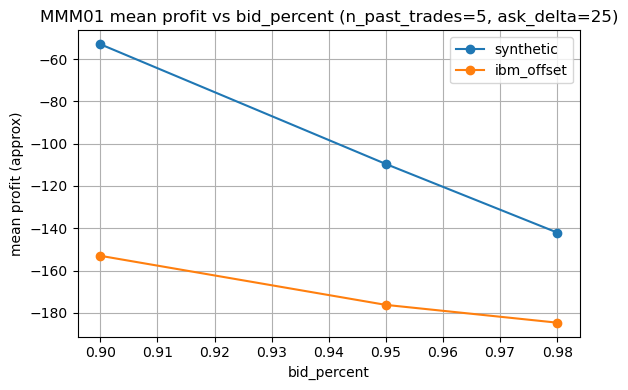

In [31]:
mask = (summary["n_past_trades"] == 5) & (summary["ask_delta"] == 25)
sub = summary[mask]

plt.figure(figsize=(6, 4))

for mt in ["synthetic", "ibm_offset"]:
    tmp = sub[sub["market_type"] == mt].sort_values("bid_percent")
    plt.plot(tmp["bid_percent"], tmp["mean_profit"], marker="o", label=mt)

plt.xlabel("bid_percent")
plt.ylabel("mean profit (approx)")
plt.title("MMM01 mean profit vs bid_percent (n_past_trades=5, ask_delta=25)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [33]:
overall = (
    summary
    .groupby(["n_past_trades", "bid_percent", "ask_delta"])
    .agg(overall_mean_profit=("mean_profit", "mean"))
    .reset_index()
)

best_row = overall.sort_values("overall_mean_profit", ascending=False).iloc[0]

best_params = {
    "n_past_trades": int(best_row["n_past_trades"]),
    "bid_percent": float(best_row["bid_percent"]),
    "ask_delta": int(best_row["ask_delta"])
}

print("Current MMM01* candidate parameters:")
print(best_params)
print("Overall mean profit:", best_row["overall_mean_profit"])


Current MMM01* candidate parameters:
{'n_past_trades': 10, 'bid_percent': 0.9, 'ask_delta': 5}
Overall mean profit: 16.2
